### c_Shuffle latent feature values  
Subset subtype, randomly select a value from each latent feature vector  
Collect selected values into a synthetic sample latent featue vector
Decode the synthetic latent samples to synthetic gene expression space samples
Predict on mix of real and synthetic data to make a superimposed learning curve  

In [6]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
DecisionTreeClassifier   ABCMeta     <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
RandomForestClassifier   ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
f1_score                 function    <function f1_score at 0x12b5e35e0>
figure                   function    <function figure at 0x14ac1c790>
glob                     module      <module 'glob' from '/Use<...>9/lib/python3.9/glob.py'>
mean                     function    <function mean at 0x12f77f0d0>
pd                       module      <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
plt                      module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
stdev                    function    <function stdev at 0x12f77f8b0>
train_test_split         function    <function train_test_split at 0x12b525700>


In [ ]:
# i-o dir for write-read of clf out / superimpose in?
# i_o/shuffle/latent_feature_sets/ for

In [ ]:
# idea: run the learning curve directly on the latent feature set
    # i.e. the encoded real samples
    # then compare to running the lc on the un-decoded synthetic latent samples

In [ ]:
# List of objects to have in memory:
    # trained decoder - BRCA - 
    # RF curve dict on input data - 
    # RF curve dict on decoded - 
    # RF curve diect on decoded synth* - 

### Imports, directory setup

In [5]:
import pandas as pd
import glob as glob

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from statistics import mean
from statistics import stdev

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [1]:
pwd

'/Users/karlberb/Documents/work/sample_count/synthetic_TCGA_data_gen/g_learning_curves'

In [3]:
ls

PDF.ipynb                            learning_curve_schematic.drawio
c_latent_sampling.ipynb              learning_curve_schematic.drawio.png
i_o/                                 shuffle.ipynb


### Target out dir:  
---------------
### i_o/shuffle  
--------------- 
Original version with decision tree was g_devel  
DT is also in 'RF again' section of c_latent_sampling

### Data
MAD5k features either taken within or across the TCGA intersection features (less LGGGBM)  
Could also run the full GEXP files, miR, and METH or combos of these as feature sets  
See Setup section in <c_latent_sampling.ipynb> for synthetic index generation - done

In [7]:
acrss_pths = sorted(glob.glob('../g_devel/data_GEXP_5k_col_norm/*.tsv'))
brca_5k_across = pd.read_csv(acrss_pths[2], sep="\t", index_col=0)

In [ ]:
# acc_5k_across = pd.read_csv(five_k[0], sep="\t", index_col=0)

In [ ]:
wthn_pths = sorted(
    glob.glob(
        '/Users/karlberb/Documents/work/sample_count/synthetic_TCGA_data_gen/g_devel/data_5k/*.tsv'))
brca_5k_within = pd.read_csv(
    wthn_pths[2], sep = '\t', index_col = 0)

In [ ]:
# acc_5k_within = pd.read_csv(
#     mad5k_wthn_pths[0], sep = '\t', index_col = 0)

### Input GEXP to VAE Learning curve

In [19]:
# DataFrame to Random Forest TOGGLE

# df_to_rf = acc_5k_across # <---
# feature_selection_method = 'across_cohort'

# df_to_rf = acc_5k_within # <---
# feature_selection_method = 'within_cohort'

# df_to_rf = brca_5k_across # <---
# feature_selection_method = 'across_cohort'

df_to_rf = brca_5k_within # <---
feature_selection_method = 'within_cohort'

print('starting learning curve generation on labled feature set')
RF_F1_dct = {}
RF_F1_means = {}
for smp_sz in list(range(50, 251, 10)): # BRCA <---
# for smp_sz in list(range(15, 76, 5)): # ACC <---
    
    print(smp_sz)
    # print(' ')
    
    stdev_lst = []
    mean_lst = []
    
    RF_output = []
    resmpl_count = 150
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_rf.sample(smp_sz)
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        RF_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
        # print(RF_output)
        
        if len(RF_output) > 1:
            stdev_lst.append(stdev(RF_output))
            mean_lst.append(mean(RF_output))
        # Active learning insertion point    
           
    RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    RF_F1_dct[smp_sz] = RF_output
    # break
print('Learning curve object generated, send to plot function')

starting learning curve generation on labled feature set
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Learning curve object generated, send to plot function


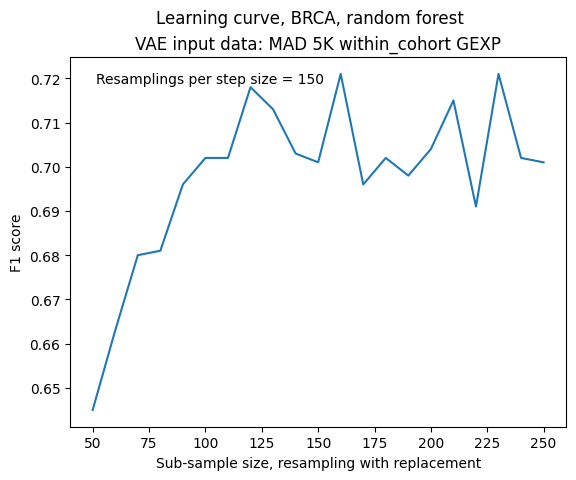

In [22]:
plt.plot(list(RF_F1_means.keys()),
       RF_F1_means.values(), label = 'Stndrd dvtn')
plt.suptitle('Learning curve, '+df_to_rf.index.name+', random forest')
plt.title('VAE input data: MAD 5K '+feature_selection_method+' GEXP') # copy and modify 
plt.ylabel('F1 score')                                                # for decoded naming
plt.xlabel('Sub-sample size, resampling with replacement')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.15, .85), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.savefig(
    'i_o/shuffle/'+
    str(df_to_rf.index.name)+'_'+feature_selection_method+'_'+ # add decoded to naming
    str(list(RF_F1_means.keys())[0])+'-to-'+str(smp_sz)+       # for post-VAE plots
    '_'+str(resmpl_count)+'-rsmpls'+
    '_v0.png', bbox_inches = 'tight')

### VAE

#### Setup VAE

In [20]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [21]:
# Function set for leave one out loop
def compute_latent(x): # x:
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

# Set custom layer , will need all this at start of shell script
class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

#### Main VAE

In [23]:
feature_set = 'mad_5k_within'
decode_df = brca_5k_within
c = brca_5k_within.index.name
fit_on = 'BRCA'

In [25]:
feature_set = 'mad_5k_across' # smooth learning curve in original
decode_df = brca_5k_across
c = brca_5k_across.index.name
fit_on = 'BRCA'

In [27]:
feature_set = 'mad_5k_within'
c = 'ACC'
fit_on = 'ACC'
decode_df = acc_5k_within

In [29]:
feature_set = 'mad_5k_across'
c = 'ACC'
fit_on = 'ACC'
decode_df = acc_5k_across

2022-11-28 12:25:49.363610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-28 12:25:49.412155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-28 12:25:49.436967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-28 12:25:49.602150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-28 12:25:49.660054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-28 12:25:49.685640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-28 12:25:50.145254: I tensorflow/core/grappler/optimizers/cust

Decode cohort trained on self using mad_5k_across feature set experiment done


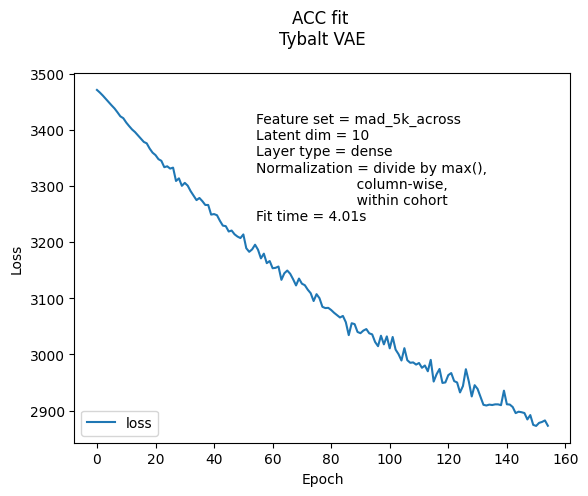

In [30]:
# Decode all samples after training on self with MAD 5k taken
  # either within or across cohort
# adapted from c_latent_sampling in g_learning curves

features = decode_df.columns[1:] # direct decode, will need fitting / dedoding frames

original_dim = len(features)
feature_dim = len(features)
latent_dim = 10

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005
kappa = 1

beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

epochs=155

fit_start = time.time()
history = vae.fit(decode_df.iloc[:, 1:],  #       <-------- fit the VAE on object toggled here
            epochs=epochs, batch_size=50, shuffle=True,
            callbacks=[WarmUpCallback(beta, kappa)],
                 verbose=0 #  <---------------------- turn this on for production *************
                 )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss")

plt.title(
    c+' fit '+
    '\nTybalt VAE\n'
         )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate('Feature set = '+feature_set+
             '\nLatent dim = '+str(latent_dim)+
             '\nLayer type = dense'+
             '\nNormalization = divide by max(),\n'+
             '                       column-wise,\n'+
             '                       within cohort'+
             '\nFit time = '+str(round(fit_end,2 ))+'s',
            xy=(.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            )

plt.legend(loc="lower left")
plt.savefig(
    'i_o/shuffle/'+c+'_'+
    'fit_on_'+fit_on+'_latent_dim.'+str(latent_dim)+
    # '_pltv-'+str(plt_v)+
    '_epochs.'+str(epochs)+'_'+
    feature_set+
    '.png', bbox_inches='tight') # version 18, norm within cohort
# plt.close()

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape=(latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = decode_df.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(decode_df.iloc[:, 1:])),
                       index=decode_df.index, columns=decode_df.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(decode_df.iloc[:, 1:]),
             index=decode_df.index,
                # columns=decode_df.iloc[:, 1:].columns # Columns are different because this is latent space
        )
latent_object.index.name = c
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv('i_o/shuffle/'+c+'_fit_on.'+fit_on+
                     '_latent_object_latent_dim.'+str(latent_dim)+
    '_epochs.'+str(epochs)+'_'+feature_set+
    '.tsv',
    sep = '\t')
# break
decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/shuffle/'+c+'_fit_on.'+fit_on+'_decoded_latent_dim.'+
    str(latent_dim)+
    '_epochs.'+str(epochs)+'_'+feature_set+
    '.tsv',
    sep = '\t')

print('Decode cohort trained on self using '+feature_set+' feature set experiment done')

### Classify on decoded samples  
'RF again' section in c_latent_sampling

In [31]:
df_to_clf = decoded_labeled # across ACC (?)


In [64]:
df_to_clf = pd.read_csv(
    'i_o/shuffle/ACC_fit_on.ACC_decoded_latent_dim.10_epochs.155_mad_5k_across.tsv',
    sep = '\t', index_col = 0)
feature_set = 'mad_5k_across'
c = 'ACC'
fit_on = 'ACC'
decode_df = acc_5k_across

In [41]:
df_to_clf = pd.read_csv(
    'i_o/shuffle/ACC_fit_on.ACC_decoded_latent_dim.10_epochs.155_mad_5k_within.tsv',
    sep = '\t', index_col = 0)
feature_set = 'mad_5k_within'
c = 'ACC'
fit_on = 'ACC'
decode_df = acc_5k_within    

In [55]:
df_to_clf = pd.read_csv(
    'i_o/shuffle/BRCA_fit_on.BRCA_decoded_latent_dim.10_epochs.155_mad_5k_within.tsv',
    sep = '\t', index_col = 0)
feature_set = 'mad_5k_within'
c = 'BRCA'
fit_on = 'BRCA'
decode_df = brca_5k_within

In [61]:
df_to_clf = pd.read_csv(
    'i_o/shuffle/BRCA_fit_on.BRCA_decoded_latent_dim.10_epochs.155_mad_5k_across.tsv',
    sep = '\t', index_col = 0)
feature_set = 'mad_5k_across'
c = 'BRCA'
fit_on = 'BRCA'
decode_df = brca_5k_across

In [66]:
RF_F1_dct = {}
RF_F1_means = {}
DT_F1_means = {}
# for smp_sz in list(range(20, 251, 10)):
for smp_sz in list(range(15, 76, 5)):       # Toggle on for ACC  <---------
    
    print(smp_sz)
    # print(' ')
    
    stdev_lst = []
    mean_lst = []
    
    RF_output = []
    DT_output = []
    resmpl_count = 150
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz)
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        DT_clf = DecisionTreeClassifier()
        RF_clf.fit(X_train, y_train)
        DT_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        DT_F1_scr = f1_score(y_test, DT_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
        DT_output.append(DT_F1_scr)
        
        if len(RF_output) > 1:
            stdev_lst.append(stdev(RF_output))
            mean_lst.append(mean(RF_output)) # running mean for active learning
           
    RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    DT_F1_means[smp_sz] = round(mean(DT_output), 3)
    RF_F1_dct[smp_sz] = RF_output
print('clf done')

15
20
25
30
35
40
45
50
55
60
65
70
75
clf done


In [67]:
feature_set

'mad_5k_across'

In [68]:
fit_on

'ACC'

In [69]:
df_to_clf.index.name

'ACC'

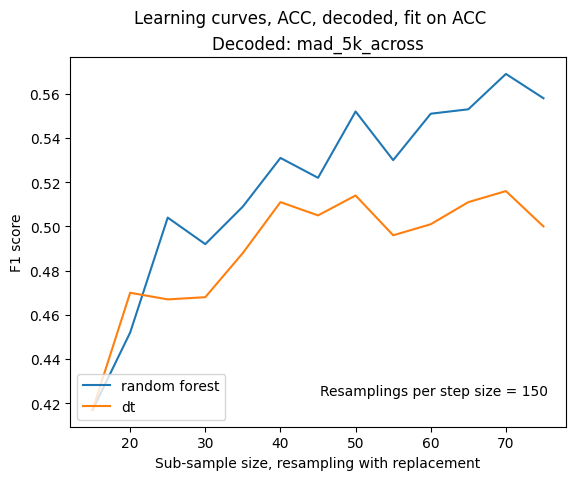

In [70]:
clf = 'random forest'
plt.plot(list(RF_F1_means.keys()),
       RF_F1_means.values(),label=clf)
plt.plot(list(DT_F1_means.keys()),
       DT_F1_means.values(),label='dt')
plt.suptitle('Learning curves, '+df_to_clf.index.name+', decoded, fit on '+
             df_to_clf.index.name)
# plt.title('VAE input data: MAD 5K GEXP')
plt.title('Decoded: ' + feature_set) # across or within cohorts
plt.ylabel('F1 score')
plt.xlabel('Sub-sample size, resampling with replacement')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .2), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc="lower left")
plt.savefig(
    'i_o/shuffle/decoded_curves/'+
    str(df_to_clf.index.name)+'.decoded_fit_on.'+fit_on +'_'+feature_set+'_'+
    str(list(RF_F1_means.keys())[0])+'-to-'+str(smp_sz)+
    '_'+'rsmpls.'+str(resmpl_count)+
    '_v0.png', bbox_inches = 'tight')

### Shuffle latent feature values  
Generate synthetic sample latent feature vector

#### Synth setup and data

In [86]:
chrt = 'ACC'
latent_obj = pd.read_csv(
    'i_o/shuffle/latent_feature_sets/ACC_fit_on.ACC_latent_object_latent_dim.10_epochs.155_mad_5k_across.tsv',
        sep = '\t', index_col = 0)

In [ ]:
latent_obj = pd.read_csv(
    'i_o/shuffle/latent_feature_sets/i_o/shuffle/ACC_fit_on.ACC_latent_object_latent_dim.10_epochs.155_mad_5k_within.tsv',
        sep = '\t', index_col = 0)

In [ ]:
i_o/shuffle/BRCA_fit_on.BRCA_latent_object_latent_dim.10_epochs.155_mad_5k_across.tsv

In [ ]:
i_o/shuffle/BRCA_fit_on.BRCA_latent_object_latent_dim.10_epochs.155_mad_5k_within.tsv

#### Synth main

In [146]:
synth_ndx_strt = 0
synth_samples_per_subtype = 100

synth_full_frame = pd.DataFrame()

# Take the reset starting index position from end of loop to create next synthetic subtype set
for subtype in sorted(latent_obj.Labels.unique()): # Subset the latent feature frame on each subtype
    print(subtype)
    sub = latent_obj[latent_obj.Labels == subtype]
    synth_lat_feat_vec = []
    
    synth_index = ['SYNTH-' + chrt + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_samples_per_subtype + synth_ndx_strt))]]
    # break
    
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    for lat_feat in sub.columns[1:]:               # Go through the subtype latent feature set,
        # print(lat_feat)                            # skipping the Labels column
        lat_col = sub.loc[:, lat_feat]
        
        rand_lat_feat_vals = lat_col.sample(
            synth_samples_per_subtype, replace = True,
            # index = synth_index
        ) # *
        rand_lat_feat_vals.index = synth_index
        synth_sub_frame = pd.concat(
            [synth_sub_frame, rand_lat_feat_vals], axis = 1)
        # break
    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0)
    # break
    synth_ndx_strt = synth_ndx_strt + synth_samples_per_subtype
    # break

ACC_1
ACC_2
ACC_3


#### Sythetic index generation

In [149]:
synth_full_frame

,Labels,0,1,2,3,4,5,6,7,8,9
SYNTH-ACC-00000,ACC_1,0.000000,0.000000,0.000000,0.00000,1.382463,0.215958,0.000000,1.076301,1.754582,0.000000
SYNTH-ACC-00001,ACC_1,0.000000,0.569945,1.356532,0.00000,2.606020,0.000000,0.000000,1.743499,1.290467,1.784984
SYNTH-ACC-00002,ACC_1,0.000000,0.834944,1.107204,0.00000,1.200183,1.403840,0.000000,1.076301,0.000000,0.000000
SYNTH-ACC-00003,ACC_1,1.504759,0.446467,0.000000,0.00000,1.594364,1.166025,0.000000,0.000000,1.619147,0.000000
SYNTH-ACC-00004,ACC_1,1.624353,0.000000,0.785319,0.00000,0.663160,1.403840,0.000000,0.000000,0.000000,1.986486
...,...,...,...,...,...,...,...,...,...,...,...
SYNTH-ACC-00295,ACC_3,1.577323,0.000000,1.107048,0.00000,0.000000,1.262425,0.000000,1.076864,1.549840,1.915816
SYNTH-ACC-00296,ACC_3,0.911690,0.000000,0.000000,1.27617,0.000000,0.045065,0.000000,0.000000,0.000000,2.076759
SYNTH-ACC-00297,ACC_3,0.911690,0.281017,1.124542,0.00000,1.370883,0.526271,0.000000,1.896240,1.030991,1.915816
SYNTH-ACC-00298,ACC_3,0.988697,0.000000,1.117186,0.00000,0.000000,1.306307,0.007447,1.724847,1.211778,0.000000


In [153]:
synth_full_frame.to_csv('i_o/shuffle/synthetic_feature_sets/'+
                        chrt+'_'+
                        str(synth_samples_per_subtype)+'_per_sbtyp.tsv',
                        sep = '\t')

In [ ]:
# write / read the synthetic latent feature object - write part is done, cont blw
# then decode it
# Then run a random forest on it, custom synthetic subsampling range
# Then plot the learning curve

In [154]:
synth_full_frame_test = pd.read_csv('i_o/shuffle/synthetic_feature_sets/'+
                        chrt+'_'+
                        str(synth_samples_per_subtype)+'_per_sbtyp.tsv',
                        sep = '\t',
                                   index_col = 0)

In [155]:
synth_full_frame_test

,Labels,0,1,2,3,4,5,6,7,8,9
SYNTH-ACC-00000,ACC_1,0.000000,0.000000,0.000000,0.00000,1.382463,0.215958,0.000000,1.076301,1.754582,0.000000
SYNTH-ACC-00001,ACC_1,0.000000,0.569945,1.356532,0.00000,2.606020,0.000000,0.000000,1.743499,1.290467,1.784984
SYNTH-ACC-00002,ACC_1,0.000000,0.834944,1.107204,0.00000,1.200183,1.403840,0.000000,1.076301,0.000000,0.000000
SYNTH-ACC-00003,ACC_1,1.504759,0.446467,0.000000,0.00000,1.594364,1.166025,0.000000,0.000000,1.619147,0.000000
SYNTH-ACC-00004,ACC_1,1.624353,0.000000,0.785319,0.00000,0.663160,1.403840,0.000000,0.000000,0.000000,1.986486
...,...,...,...,...,...,...,...,...,...,...,...
SYNTH-ACC-00295,ACC_3,1.577323,0.000000,1.107048,0.00000,0.000000,1.262425,0.000000,1.076864,1.549840,1.915816
SYNTH-ACC-00296,ACC_3,0.911690,0.000000,0.000000,1.27617,0.000000,0.045065,0.000000,0.000000,0.000000,2.076759
SYNTH-ACC-00297,ACC_3,0.911690,0.281017,1.124542,0.00000,1.370883,0.526271,0.000000,1.896240,1.030991,1.915816
SYNTH-ACC-00298,ACC_3,0.988697,0.000000,1.117186,0.00000,0.000000,1.306307,0.007447,1.724847,1.211778,0.000000


### Classify on synthetic samples

In [156]:
df_to_clf = synth_full_frame_test

In [157]:
# RF_F1_dct = {} # is this vestigial from some early high-resolution plot?

RF_F1_means = {}
# DT_F1_means = {}

# for smp_sz in list(range(20, 251, 10)):
# for smp_sz in list(range(15, 76, 5)):       # Toggle on for real ACC  <---------
    
for smp_sz in list(range(10, 100, 5)):       # Toggle on for synthetic ACC  <---------    
    
    print(smp_sz)
    # print(' ')
    
    stdev_lst = []
    mean_lst = []
    
    RF_output = []
    # DT_output = []
    
    resmpl_count = 150
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz)
        X = labeled_sample_subset_frame.iloc[:, 1:]
        y = labeled_sample_subset_frame.iloc[:, 0]
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                        test_size=0.33,
                            )
        RF_clf = RandomForestClassifier(max_depth=2)
        # DT_clf = DecisionTreeClassifier()
        RF_clf.fit(X_train, y_train)
        # DT_clf.fit(X_train, y_train)

        RF_F1_scr = f1_score(y_test, RF_clf.predict(X_test), average='weighted')
        # DT_F1_scr = f1_score(y_test, DT_clf.predict(X_test), average='weighted')
        RF_output.append(RF_F1_scr)
        # DT_output.append(DT_F1_scr)
        
        # if len(RF_output) > 1:
        #     stdev_lst.append(stdev(RF_output))
        #     mean_lst.append(mean(RF_output)) # running mean for active learning
           
    RF_F1_means[smp_sz] = round(mean(RF_output), 3)
    # DT_F1_means[smp_sz] = round(mean(DT_output), 3)
    
    # RF_F1_dct[smp_sz] = RF_output # vestigial storage object, storing the full-resoltion prediction results
    
print('clf done')

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
clf done


In [158]:
df_to_clf.index.name

In [159]:
df_to_clf.index.name = 'ACC' # go back and insert this somewhere

In [160]:
df_to_clf.index.name

'ACC'

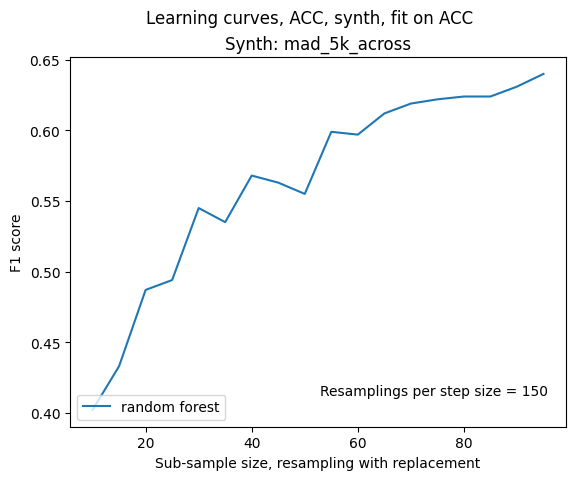

In [161]:
clf = 'random forest'
plt.plot(list(RF_F1_means.keys()),
       RF_F1_means.values(),label=clf)
# plt.plot(list(DT_F1_means.keys()),
#        DT_F1_means.values(),label='dt')
plt.suptitle('Learning curves, '+df_to_clf.index.name+', synth, fit on '+
             df_to_clf.index.name)
# plt.title('VAE input data: MAD 5K GEXP')
plt.title('Synth: ' + feature_set) # across or within cohorts
plt.ylabel('F1 score')
plt.xlabel('Sub-sample size, resampling with replacement')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .2), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc="lower left")
plt.savefig(
    'i_o/shuffle/synth_curves/'+
    str(df_to_clf.index.name)+'.synth_fit_on.'+fit_on +'_'+feature_set+'_'+
    str(list(RF_F1_means.keys())[0])+'-to-'+str(smp_sz)+
    '_'+'rsmpls.'+str(resmpl_count)+
    '_v0.png', bbox_inches = 'tight')

In [ ]:
# End 2022-11-28, Monday afternoon
# Build-out the super position plots
    # work on file naming
# Last line of paper: can do better

# Class imbalance is optimization,
    # deal with later
    # maintaining class imbalanace could return closer to input F1
    # because the larger classes might be better defined

### Shuffle devel

In [ ]:
target ouput dir:
i_o/shuffle/synthetic_feature_sets

In [110]:
[str(
    item).zfill(
    5) for item in list(range(
    synth_ndx_strt, synth_samples_per_subtype + synth_ndx_strt,))] # production

['00000',
 '00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009',
 '00010',
 '00011',
 '00012',
 '00013',
 '00014',
 '00015',
 '00016',
 '00017',
 '00018',
 '00019',
 '00020',
 '00021',
 '00022',
 '00023',
 '00024',
 '00025',
 '00026',
 '00027',
 '00028',
 '00029',
 '00030',
 '00031',
 '00032',
 '00033',
 '00034',
 '00035',
 '00036',
 '00037',
 '00038',
 '00039',
 '00040',
 '00041',
 '00042',
 '00043',
 '00044',
 '00045',
 '00046',
 '00047',
 '00048',
 '00049',
 '00050',
 '00051',
 '00052',
 '00053',
 '00054',
 '00055',
 '00056',
 '00057',
 '00058',
 '00059',
 '00060',
 '00061',
 '00062',
 '00063',
 '00064',
 '00065',
 '00066',
 '00067',
 '00068',
 '00069',
 '00070',
 '00071',
 '00072',
 '00073',
 '00074',
 '00075',
 '00076',
 '00077',
 '00078',
 '00079',
 '00080',
 '00081',
 '00082',
 '00083',
 '00084',
 '00085',
 '00086',
 '00087',
 '00088',
 '00089',
 '00090',
 '00091',
 '00092',
 '00093',
 '00094',
 '00095',
 '00096',
 '00097',
 '00098',
 '00099']